## K Means Clustering

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

(200, 200, 3)


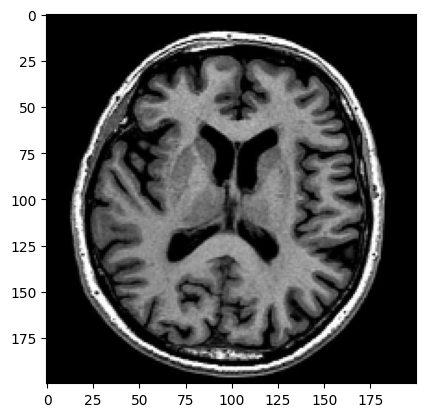

In [5]:
im =  cv2.resize(cv2.imread('x.jpg') ,(200,200))
# Reads an image into BGR Format

im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
original_shape = im.shape
print(im.shape)
plt.imshow(im) # as RGB Format
plt.show()

In [6]:
all_pixels  = im.reshape((-1,3))

from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters,max_iter=1)
km.fit(all_pixels)

/home/akshat/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1, n_clusters=3)

In [7]:
centers = km.cluster_centers_
print(centers) # In RGB Format

centers = np.array(centers,dtype='uint8')
print(centers)

[[  4.61629575   4.61629575   4.61629575]
 [161.49713762 161.49713762 161.49713762]
 [ 89.3406195   89.3406195   89.3406195 ]]
[[  4   4   4]
 [161 161 161]
 [ 89  89  89]]


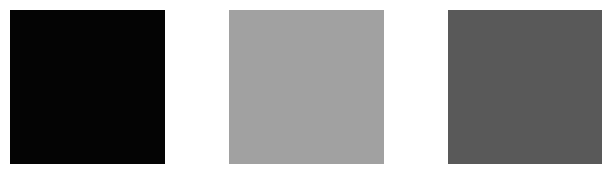

In [8]:
i = 1

plt.figure(0,figsize=(8,2))

# Storing info in color array
colors = []

for each_col in centers:
    plt.subplot(1,3,i)
    plt.axis("off")
    i+=1
        
    colors.append(each_col)
    
    # Color Swatch
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = each_col
    plt.imshow(a)
    
plt.show()

In [9]:
label_image=km.labels_.reshape(original_shape[:2])
label_image.shape

(200, 200)

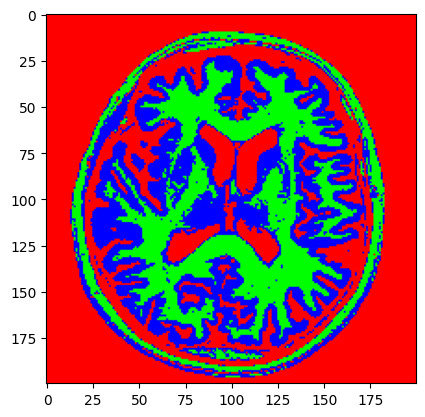

In [10]:
# Iterate over the image
new_img = np.zeros((all_pixels.shape[0],all_pixels.shape[1]),dtype='uint8')

coloras = [np.array([255, 0, 0]), np.array([0,255, 0]), np.array([0, 0, 255])]
for ix in range(new_img.shape[0]):
    new_img[ix] = coloras[km.labels_[ix]]
new_img = new_img.reshape((original_shape))
plt.imshow(new_img)
plt.show()

In [11]:
mean_pos=[[0,0] for i in range(num_clusters)]
for i in range(num_clusters):
    z=0
    for j in range(original_shape[0]):
        for k in range(original_shape[1]):
            if label_image[j][k]==i:
                mean_pos[i][0]+=j
                mean_pos[i][1]+=k
                z+=1
    mean_pos[i][0]/=z
    mean_pos[i][1]/=z

## Hybrid ACO-KMeans

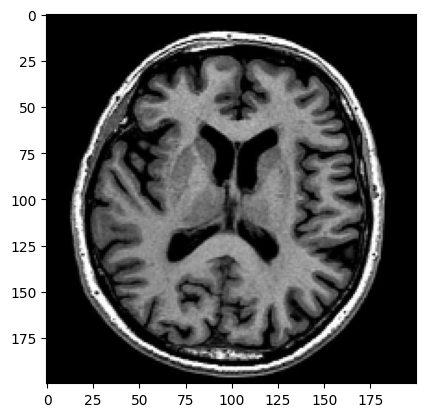

In [12]:
import random

image = im
# image =  cv2.imread('brain') 
# Reads an image into BGR Format
# image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [13]:
num_clusters = 3
num_ants = 6
alpha = 1.5
beta = 2.5
Q = 150
rho = 0.2
C = 10
max_iter=10
max_iter_ant=10

X_len=image.shape[0]
Y_len=image.shape[1]

pheromone=[[[1 for _ in range(num_clusters)]for _ in range(Y_len)]for _ in range(X_len)]

In [14]:
probs=[[[[1/num_clusters for i in range(num_clusters)]for j in range(Y_len)]for k in range(X_len)]for l in range(num_ants)]

# spatial_centers=[mean_pos for l in range(num_ants)]
# spectral_centers=[centers for l in range(num_ants)]
init_centers=[[random.randint(0,X_len-1),random.randint(0,Y_len-1)] for i in range(num_clusters)]
spatial_centers=[init_centers for l in range(num_ants)]
spectral_centers=[[ image[i][j] for i,j in spatial_centers[l]]for l in range(num_ants)]

# initial_spatial = spatial_centers
# initial_spectral = spectral_centers

memberships=[[[random.randint(0,num_clusters-1)for i in range(Y_len)]for j in range(X_len)]for l in range(num_ants)]

In [15]:
from numpy.linalg import norm 

def CDist(i,j,k,a):
    return norm((np.array(spectral_centers[a][k])-np.array(image[i][j])),2)

def PDist(i,j,k,a):
    return norm(np.array(spatial_centers[a][k])-np.array([i,j]),2)

In [16]:
def update_probability(a):    
    global probs
    probs[a] = []
    for i in range(X_len):
        pixel_i_prob_values = []
        for j in range(Y_len):    
            pixel_j_prob_values = []
            SUM = 0
            for k in range(num_clusters):
                eta = 1/(C+(CDist(i,j,k,a)*PDist(i,j,k,a)))
                pixel_j_prob_values.append((pheromone[i][j][k]**alpha)*(eta**beta))
                SUM += (pheromone[i][j][k]**alpha)*(eta**beta)
            for k in range(num_clusters):
                pixel_j_prob_values[k] /= SUM
            pixel_i_prob_values.append(pixel_j_prob_values)
        probs[a].append(pixel_i_prob_values)

In [17]:
def update_memberships_random(a):
    global memberships
    
    for i in range(X_len):
        for j in range(Y_len):
            cummulative_prob=0
            c=[]
            for k in probs[a][i][j]:
                cummulative_prob+=k
                c.append(cummulative_prob)
            random_num=random.random()
            selected=-1
            for k in range(len(c)):
                if c[k]>random_num:
                    selected=k
                    break
            memberships[a][i][j]=selected

In [18]:
def update_cluster_centers_hard(a):
    global spectral_centers,spatial_centers

    for k in range(num_clusters):
        spatial=np.array([0,0])
        SUM=0
        spectral=np.array([0,0,0])
        for i in range(X_len):
            for j in range(Y_len):
                if memberships[a][i][j]==k:
                    spatial+=np.array([i,j])
                    spectral+=np.array(image[i][j])
                    SUM+=1
        spatial_centers[a][k]=[spa/SUM for spa in spatial]
        spectral_centers[a][k]=[spec/SUM for spec in spectral]

In [19]:
def Dist(C1,C2):
    return norm(np.array(C1)-np.array(C2),2)

def f1(a):
    SUM = 0
    for i in range(num_clusters-1):
        for j in range(i+1, num_clusters):
            SUM += Dist(spectral_centers[a][i], spectral_centers[a][j])
    return SUM

def f2(a):
    SUM = 0
    for i in range(X_len):
        for j in range(Y_len):
            SUM += Dist(spatial_centers[a][memberships[a][i][j]], [i,j])
    return SUM

def f3(a):
    SUM = 0
    for i in range(X_len):
        for j in range(Y_len):
            SUM += Dist(spectral_centers[a][memberships[a][i][j]], image[i][j])
    return SUM


In [20]:
def select_best_solution():
    f1_values = [f1(a) for a in range(num_ants)]
    f2_values = [f2(a) for a in range(num_ants)]
    f3_values = [f3(a) for a in range(num_ants)]
    f1_normalised_values = [(val-min(f1_values))/(0.1+(max(f1_values)-min(f1_values))) for val in f1_values]
    f2_normalised_values = [(val-min(f2_values))/(0.1+(max(f2_values)-min(f2_values))) for val in f2_values]
    f3_normalised_values = [(val-min(f3_values))/(0.1+(max(f3_values)-min(f3_values))) for val in f3_values]
    
    # additive objective function, coefficients chosen to be 1/3, since no importance of any particular specified
    obj_func_values = [(val1-val2-val3)/3 for val1, val2, val3 in zip(f1_normalised_values, f2_normalised_values, f3_normalised_values)]
    best_ant = obj_func_values.index(max(obj_func_values))
    return best_ant, max(obj_func_values), f1_values[best_ant], f2_values[best_ant], f3_values[best_ant]
    # return spectral_center_solutions[best_ant], spatial_center_solutions[best_ant], label_solutions[best_ant]

In [21]:
f1_values = [f1(a) for a in range(num_ants)]
f2_values = [f2(a) for a in range(num_ants)]
f3_values = [f3(a) for a in range(num_ants)]

In [22]:
f1_values, f2_values, f3_values

([3.4641016151377544,
  3.4641016151377544,
  3.4641016151377544,
  3.4641016151377544,
  3.4641016151377544,
  3.4641016151377544],
 [4736526.541274292,
  4732935.928639428,
  4746808.716521138,
  4763011.6103626145,
  4736897.306551454,
  4739788.796618901],
 [7090444.429419992,
  7091591.047054591,
  7093047.701783803,
  7089910.957771267,
  7081468.942135271,
  7087283.436696245])

In [23]:
spectral_centers[2]

[array([1, 1, 1], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8)]

In [24]:
a = [[1,5]]*3
a[1].append(0)
a[2].append(3)
a

[[1, 5, 0, 3], [1, 5, 0, 3], [1, 5, 0, 3]]

In [25]:
def update_pheromone(best_ant): #Q is a constant value
    # pheromone=[[[1 for i in range(num_clusters)]for j in range(Y_len)]for k in range(X_len)]
    
    min_c_dist = math.inf
    for i in range(num_clusters):
        for j in range(num_clusters):
            if not i==j:
                new_dist = Dist(spectral_centers[best_ant][i], spectral_centers[best_ant][j])
                if(new_dist < min_c_dist): min_c_dist = new_dist
                    
    cluster_set = [[]for i in range(num_clusters)]
    for i in range(X_len):
        for j in range(Y_len):
            label = memberships[best_ant][i][j]
            cluster_set[label].append([i,j])
                
    avg_c_dists = []
    avg_p_dists = []
    for i in range(num_clusters):
        sumc = 0
        sump = 0
        for pixel in cluster_set[i]:
            sumc += Dist(image[pixel[0],pixel[1]], spectral_centers[i])
            sump += Dist(pixel, spatial_centers[i])
        avg_c_dists.append(sumc/len(cluster_set[i]))
        avg_p_dists.append(sump/len(cluster_set[i]))

    deposited_pheromones = []
    for i in range(num_clusters):
        deposited_pheromones.append((Q*min_c_dist)/(avg_c_dists[i]*avg_p_dists[i]))
        
    for i in range(X_len):
        for j in range(Y_len):
            label = memberships[best_ant][i][j]
            for k in range(num_clusters):
                if(k == label):
                    pheromone[i][j][k] = (1-rho)*pheromone[i][j][k] + deposited_pheromones[k]
                else:
                    pheromone[i][j][k] = (1-rho)*pheromone[i][j][k] 

In [26]:
def print_label_correct(a):
    # colors=[spectral_centers[a][i] for i in range(num_clusters)]
    new_image = np.zeros((image.shape[0],image.shape[1],3),dtype='uint8')
    # Iterate over the image
    coloras = [np.array(spectral_centers[a][0]), np.array(spectral_centers[a][1]), np.array(spectral_centers[a][2])]
#     coloras = [np.array([255,0,0]), np.array([0,255,0]), np.array([0,0,255])]
    for i in range(X_len):
        for j in range(Y_len):
            new_image[i][j] = coloras[memberships[a][i][j]]
    plt.imshow(new_image)
    plt.show()
    # for i in range(X_len):
    #     for j in range(Y_len):
    #         new_image[i][j]=colors[memberships[a][i][j]]

In [27]:
def print_label_image(a):
    # colors=[spectral_centers[a][i] for i in range(num_clusters)]
    new_image = np.zeros((image.shape[0],image.shape[1],3),dtype='uint8')
    # Iterate over the image
#     coloras = [np.array(spectral_centers[a][0]), np.array(spectral_centers[a][1]), np.array(spectral_centers[a][2])
    coloras = [np.array([255,0,0]), np.array([0,255,0]), np.array([0,0,255])]
    for i in range(X_len):
        for j in range(Y_len):
            new_image[i][j] = coloras[memberships[a][i][j]]
    plt.imshow(new_image)
    plt.show()
    # for i in range(X_len):
    #     for j in range(Y_len):
    #         new_image[i][j]=colors[memberships[a][i][j]]

In [28]:
best_ant_labels=[]
f1_value_progress = []
f2_value_progress = []
f3_value_progress = []
obj_func_values_progress = []

In [29]:
def Hybrid_ACO_KMeans():
    prev_obj_func_value = math.inf
    global spatial_centers, spectral_centers, memberships
    
    _,obj_func_value, f1_best, f2_best, f3_best = select_best_solution()
    f1_value_progress.append(f1_best)
    f2_value_progress.append(f2_best)
    f3_value_progress.append(f3_best)
    obj_func_values_progress.append(obj_func_value)
    
    
    for i in range(max_iter):
        init_spat=[[spatial_centers[a1][b] for b in range(num_clusters)]for a1 in range(num_ants)]
        init_spec=[[spectral_centers[a1][b] for b in range(num_clusters)]for a1 in range(num_ants)]
        for a in range(num_ants):            
            for j in range(max_iter_ant):
                prev_memberships = [[memberships[a][i1][j1] for j1 in range(Y_len)]for i1 in range(X_len)]
                
                update_probability(a)
                update_memberships_random(a)
                update_cluster_centers_hard(a)

                if memberships[a] == prev_memberships:
                    print("broke at",j)
                    break
                # print_label_image(a)
            print("Ant", a)
        
        best_ant, obj_func_value, f1_best, f2_best, f3_best = select_best_solution()
        f1_value_progress.append(f1_best)
        f2_value_progress.append(f2_best)
        f3_value_progress.append(f3_best)
        obj_func_values_progress.append(obj_func_value)
        # if(obj_func_value > prev_obj_func_value):
        #     break
            
        print("Best Ant:", best_ant, ", Objective Function value:", obj_func_value)
        best_ant_labels.append([[memberships[best_ant][i1][j1]for j1 in range(Y_len)]for i1 in range(X_len)])
        update_pheromone(best_ant)
        print_label_correct(best_ant)
        print_label_image(best_ant)
        spatial_centers = init_spat
        spectral_centers = init_spec
        prev_obj_func_value = obj_func_value

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 1 , Objective Function value: 0.19135810879025492


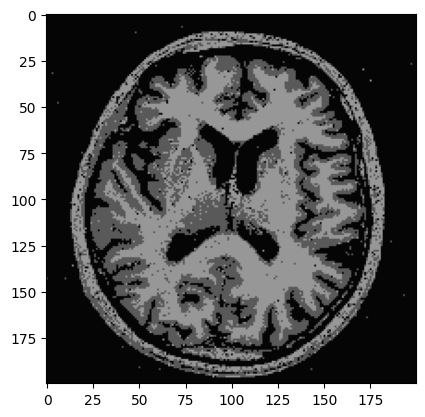

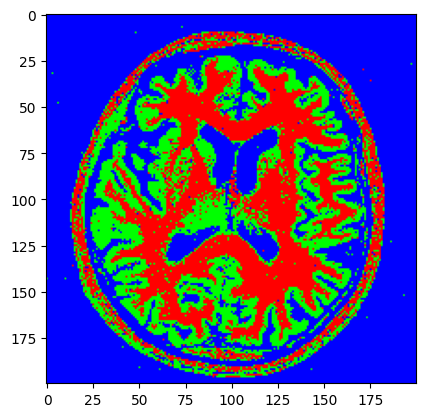

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 4 , Objective Function value: 0.27328061521779784


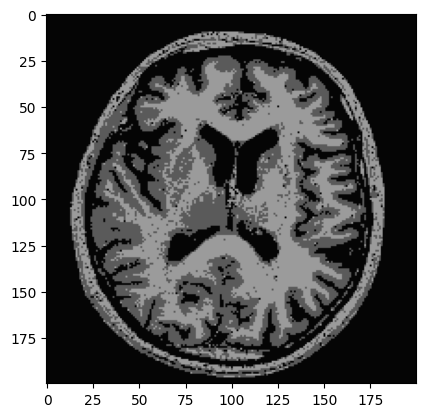

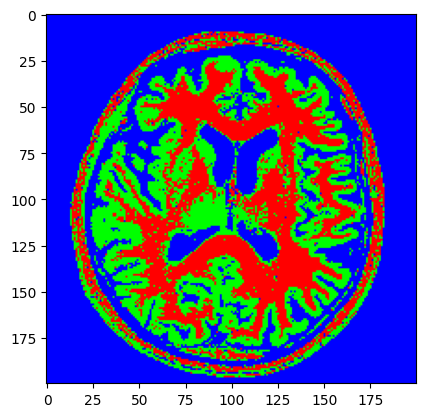

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 4 , Objective Function value: 0.18598184273076224


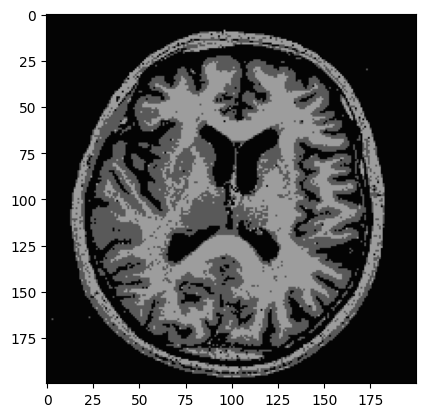

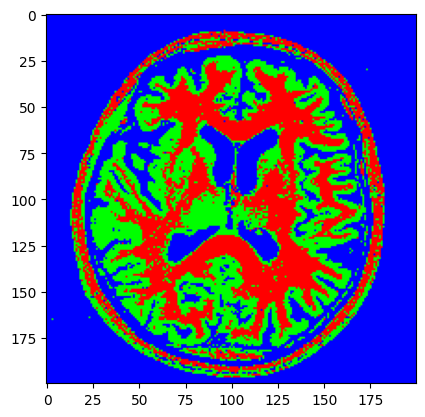

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 4 , Objective Function value: 0.007691900476074265


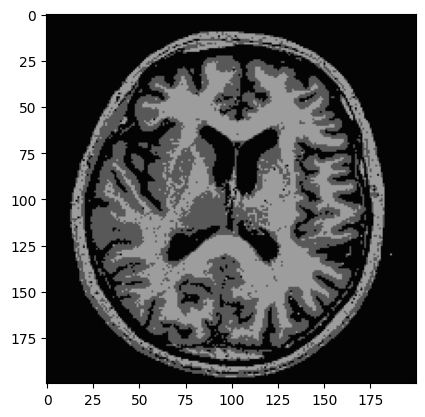

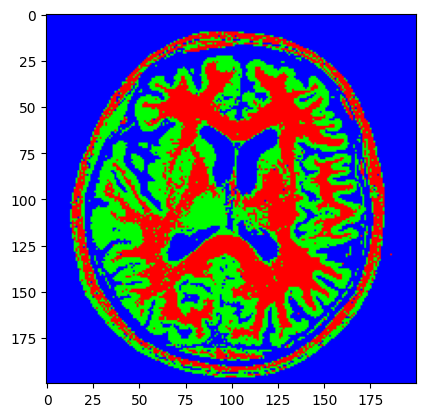

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 3 , Objective Function value: 0.12944145991836478


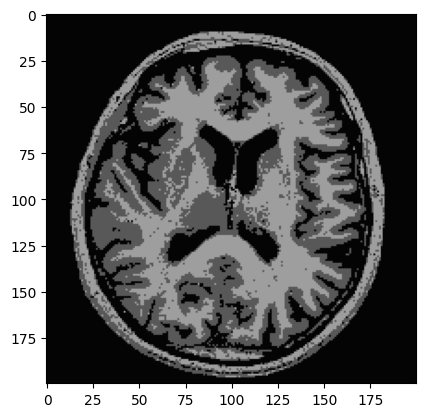

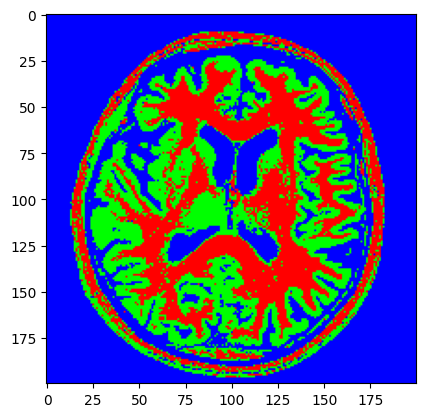

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 4 , Objective Function value: 0.24070824769758326


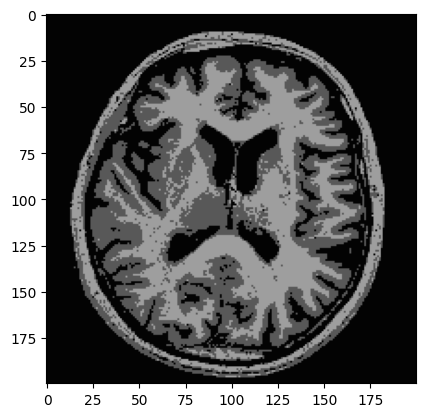

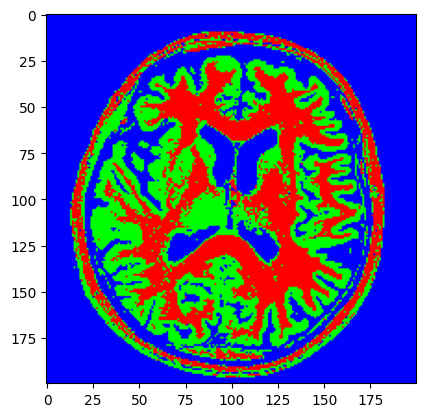

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 5 , Objective Function value: 0.012712868347071601


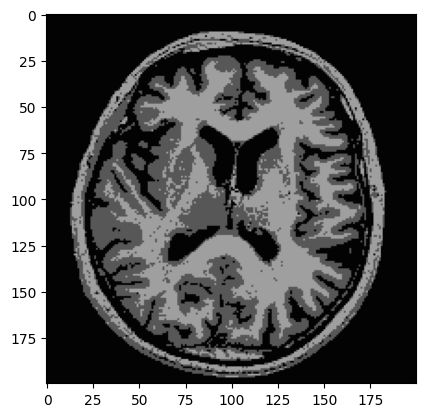

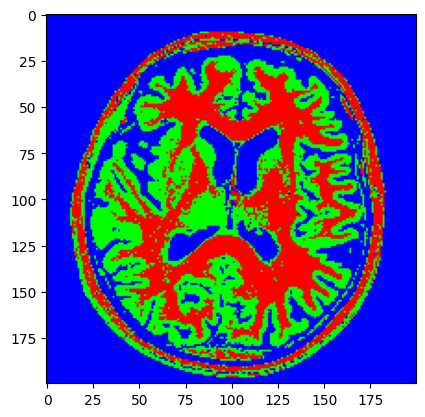

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 2 , Objective Function value: 0.1512927906184684


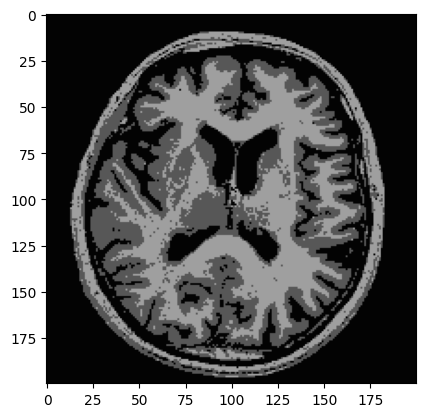

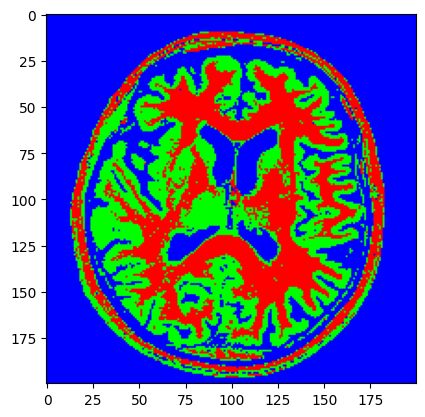

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 5 , Objective Function value: 0.0386408712300188


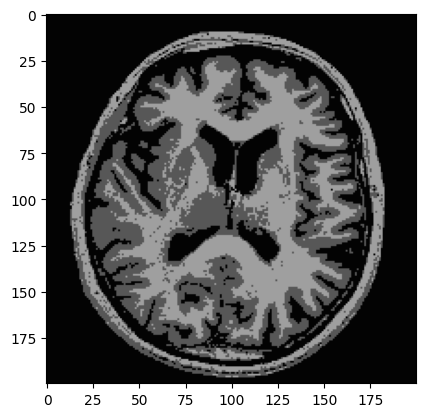

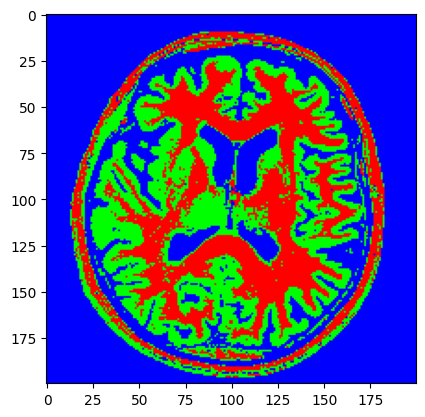

Ant 0
Ant 1
Ant 2
Ant 3
Ant 4
Ant 5
Best Ant: 2 , Objective Function value: 0.09925331388690621


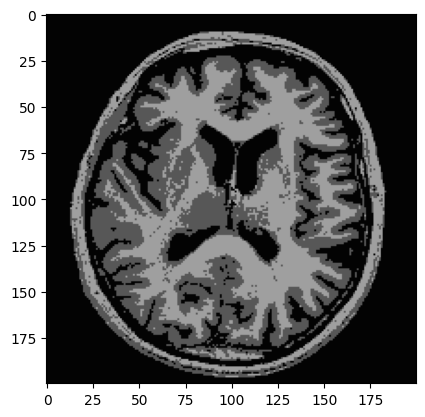

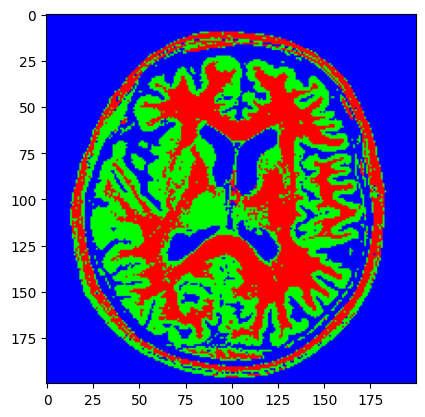

In [30]:
Hybrid_ACO_KMeans()

In [31]:
pheromone

[[[0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0.10737418240000006, 1.781753968884479],
  [0.10737418240000006, 0

In [32]:
f3_value_progress

[7081468.942135271,
 1068266.455559721,
 1023311.6740582307,
 992172.5476119034,
 973655.2733560178,
 955396.059045133,
 951054.4685938227,
 946316.7295069279,
 942274.9258630025,
 940788.6851990056,
 937302.7311735548]

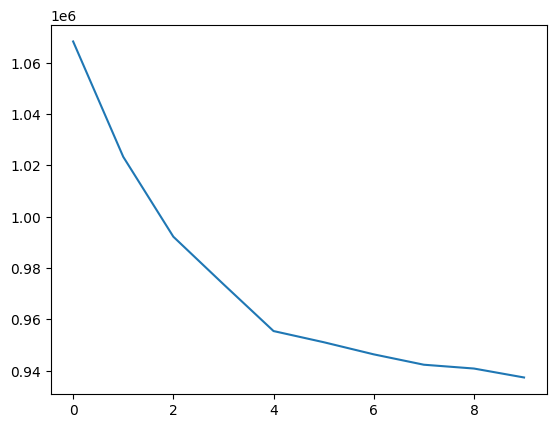

In [33]:
plt.plot(range(len(f3_value_progress)-1),f3_value_progress[1:])


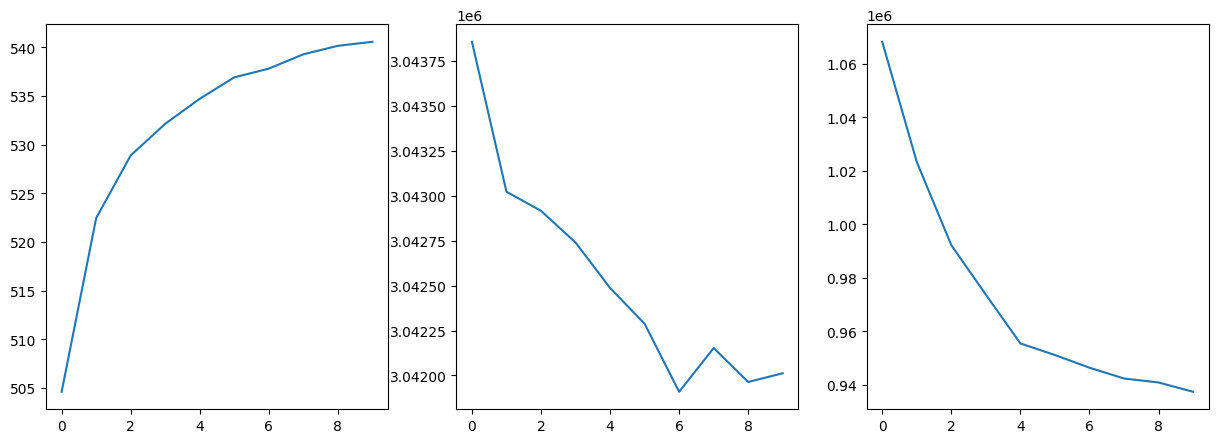

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(len(f1_value_progress)-1),f1_value_progress[1:])

plt.subplot(1, 3, 2)
plt.plot(range(len(f2_value_progress)-1),f2_value_progress[1:] )

plt.subplot(1, 3, 3)
plt.plot(range(len(f3_value_progress)-1),f3_value_progress[1:] )

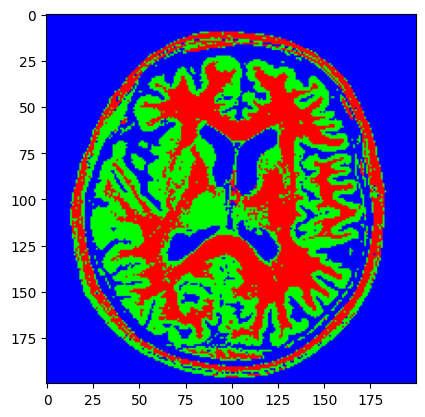

In [36]:
new_image = np.zeros(
            (image.shape[0], image.shape[1], 3), dtype='uint8')
for i1 in range(X_len):
    for j in range(Y_len):
        new_image[i1][j] = coloras[best_ant_labels[9][i1][j]]
plt.imshow(new_image)

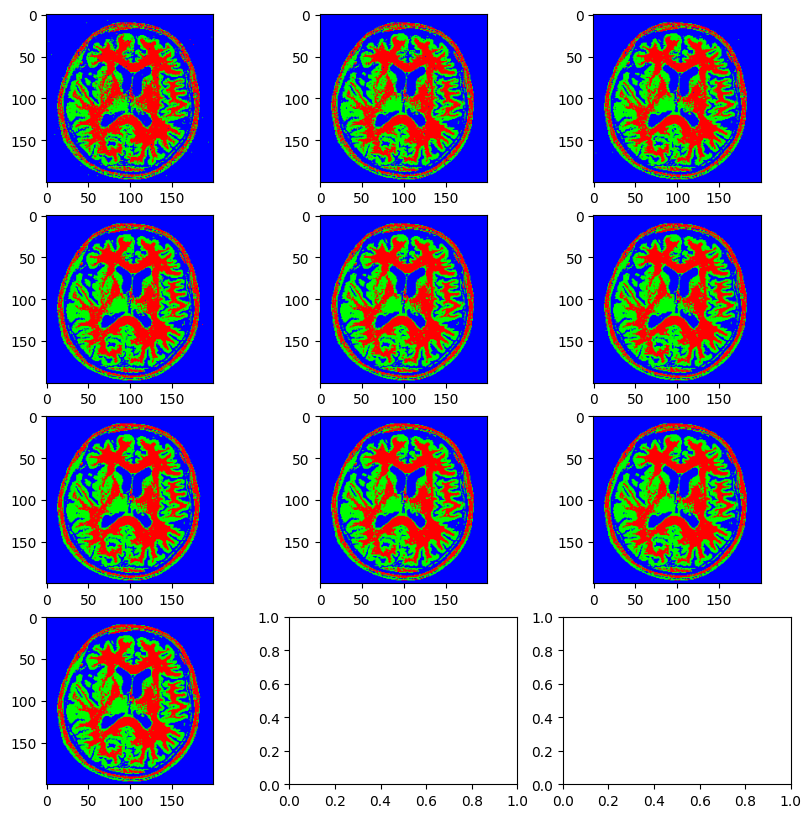

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
coloras = [np.array([255, 0, 0]), np.array([0, 255, 0]), np.array([0, 0, 255])]

for i, ax in enumerate(axes.flatten()):
    if i < 10:
        new_image = np.zeros(
            (image.shape[0], image.shape[1], 3), dtype='uint8')
        for i1 in range(X_len):
            for j in range(Y_len):
                new_image[i1][j] = coloras[best_ant_labels[i][i1][j]]
        ax.imshow(new_image)
plt.show()


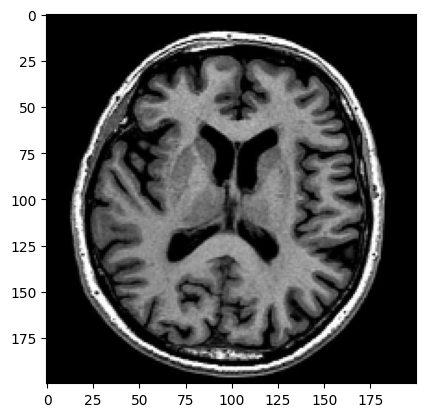

In [38]:
plt.imshow(image)

In [39]:
# def ACO_KMeans():
#     a = 0
#     global spatial_centers, spectral_centers
#     for i in range(5):
#         init_spat=[[spatial_centers[a][b] for b in range(num_clusters)]for a in range(num_ants)]
#         init_spec=[[spectral_centers[a][b] for b in range(num_clusters)]for a in range(num_ants)]
        
#         for j in range(5):
#             prev_memberships = [[memberships[a][i][j] for j in range(Y_len)]for i in range(X_len)]
#             update_probability(a)
#             update_memberships_random(a)
#             print_label_image(a)
            
#             update_cluster_centers_hard(a)

#             if memberships[a] == prev_memberships:
#                 print("broke at",j)
#                 break  
                
#         update_pheromone(0)
#         spatial_centers = init_spat
#         spectral_centers = init_spec
#         print("Ek round zhala")